# Description

This notebook is for fine tuning yolo to segment a given 3D platelet image into four organelles.

# Imports

In [27]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import PIL 
import yaml
from IPython.display import display
import numpy as np

# Loading pretrained model

In [3]:
model = YOLO("yolo11n-seg.yaml")  # build a new model from YAML
model = YOLO("yolo11n-seg.pt")  # load a pretrained model (recommended for training)

# Begin

In [4]:
with open("./yolo_dataset/data.yaml", "r") as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

num_classes

'4'

In [5]:
project = "./results"
name = "first_training_results"

In [ ]:
results = model.train(data="./yolo_dataset/data.yaml", 
                      project=project,
                      epochs=200,
                      patience=0,
                      batch=4,
                      imgsz=800
                      )

In [6]:
model = YOLO('results/train/weights/best.pt')

# Metrics (mAP)

In [7]:
metrics = model.val(data='./yolo_dataset/data.yaml', imgsz=800)

Ultralytics 8.3.141  Python-3.12.0 torch-2.7.0+cpu CPU (AMD Ryzen 7 5800H with Radeon Graphics)
YOLO11n-seg summary (fused): 113 layers, 2,835,348 parameters, 0 gradients, 10.2 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 529.454.3 MB/s, size: 481.0 KB)


val: Scanning C:\Users\acer\Desktop\Code\YOLO\yolo_dataset\valid\labels.cache... 23 images, 0 backgrounds, 0 corrupt: 100%|██████████| 23/23 [00:00<?, ?it/s]
c:\Users\acer\Desktop\Code\YOLO\venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validati

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:04<00:04,  4.92s/it]

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.99s/it]


                   all         23       1709      0.772       0.68      0.748      0.453      0.762       0.67      0.746      0.415
                 Alpha         23        637      0.868      0.667      0.792      0.492       0.87      0.671      0.797      0.462
                  Mito         23         94      0.708      0.553      0.659      0.428      0.706      0.553      0.674       0.42
               Vessels         23        978      0.739      0.818      0.793      0.438       0.71      0.787      0.768      0.363
Speed: 4.7ms preprocess, 185.2ms inference, 0.0ms loss, 11.0ms postprocess per image
Results saved to runs\segment\val


# Confusion matrix on validation set

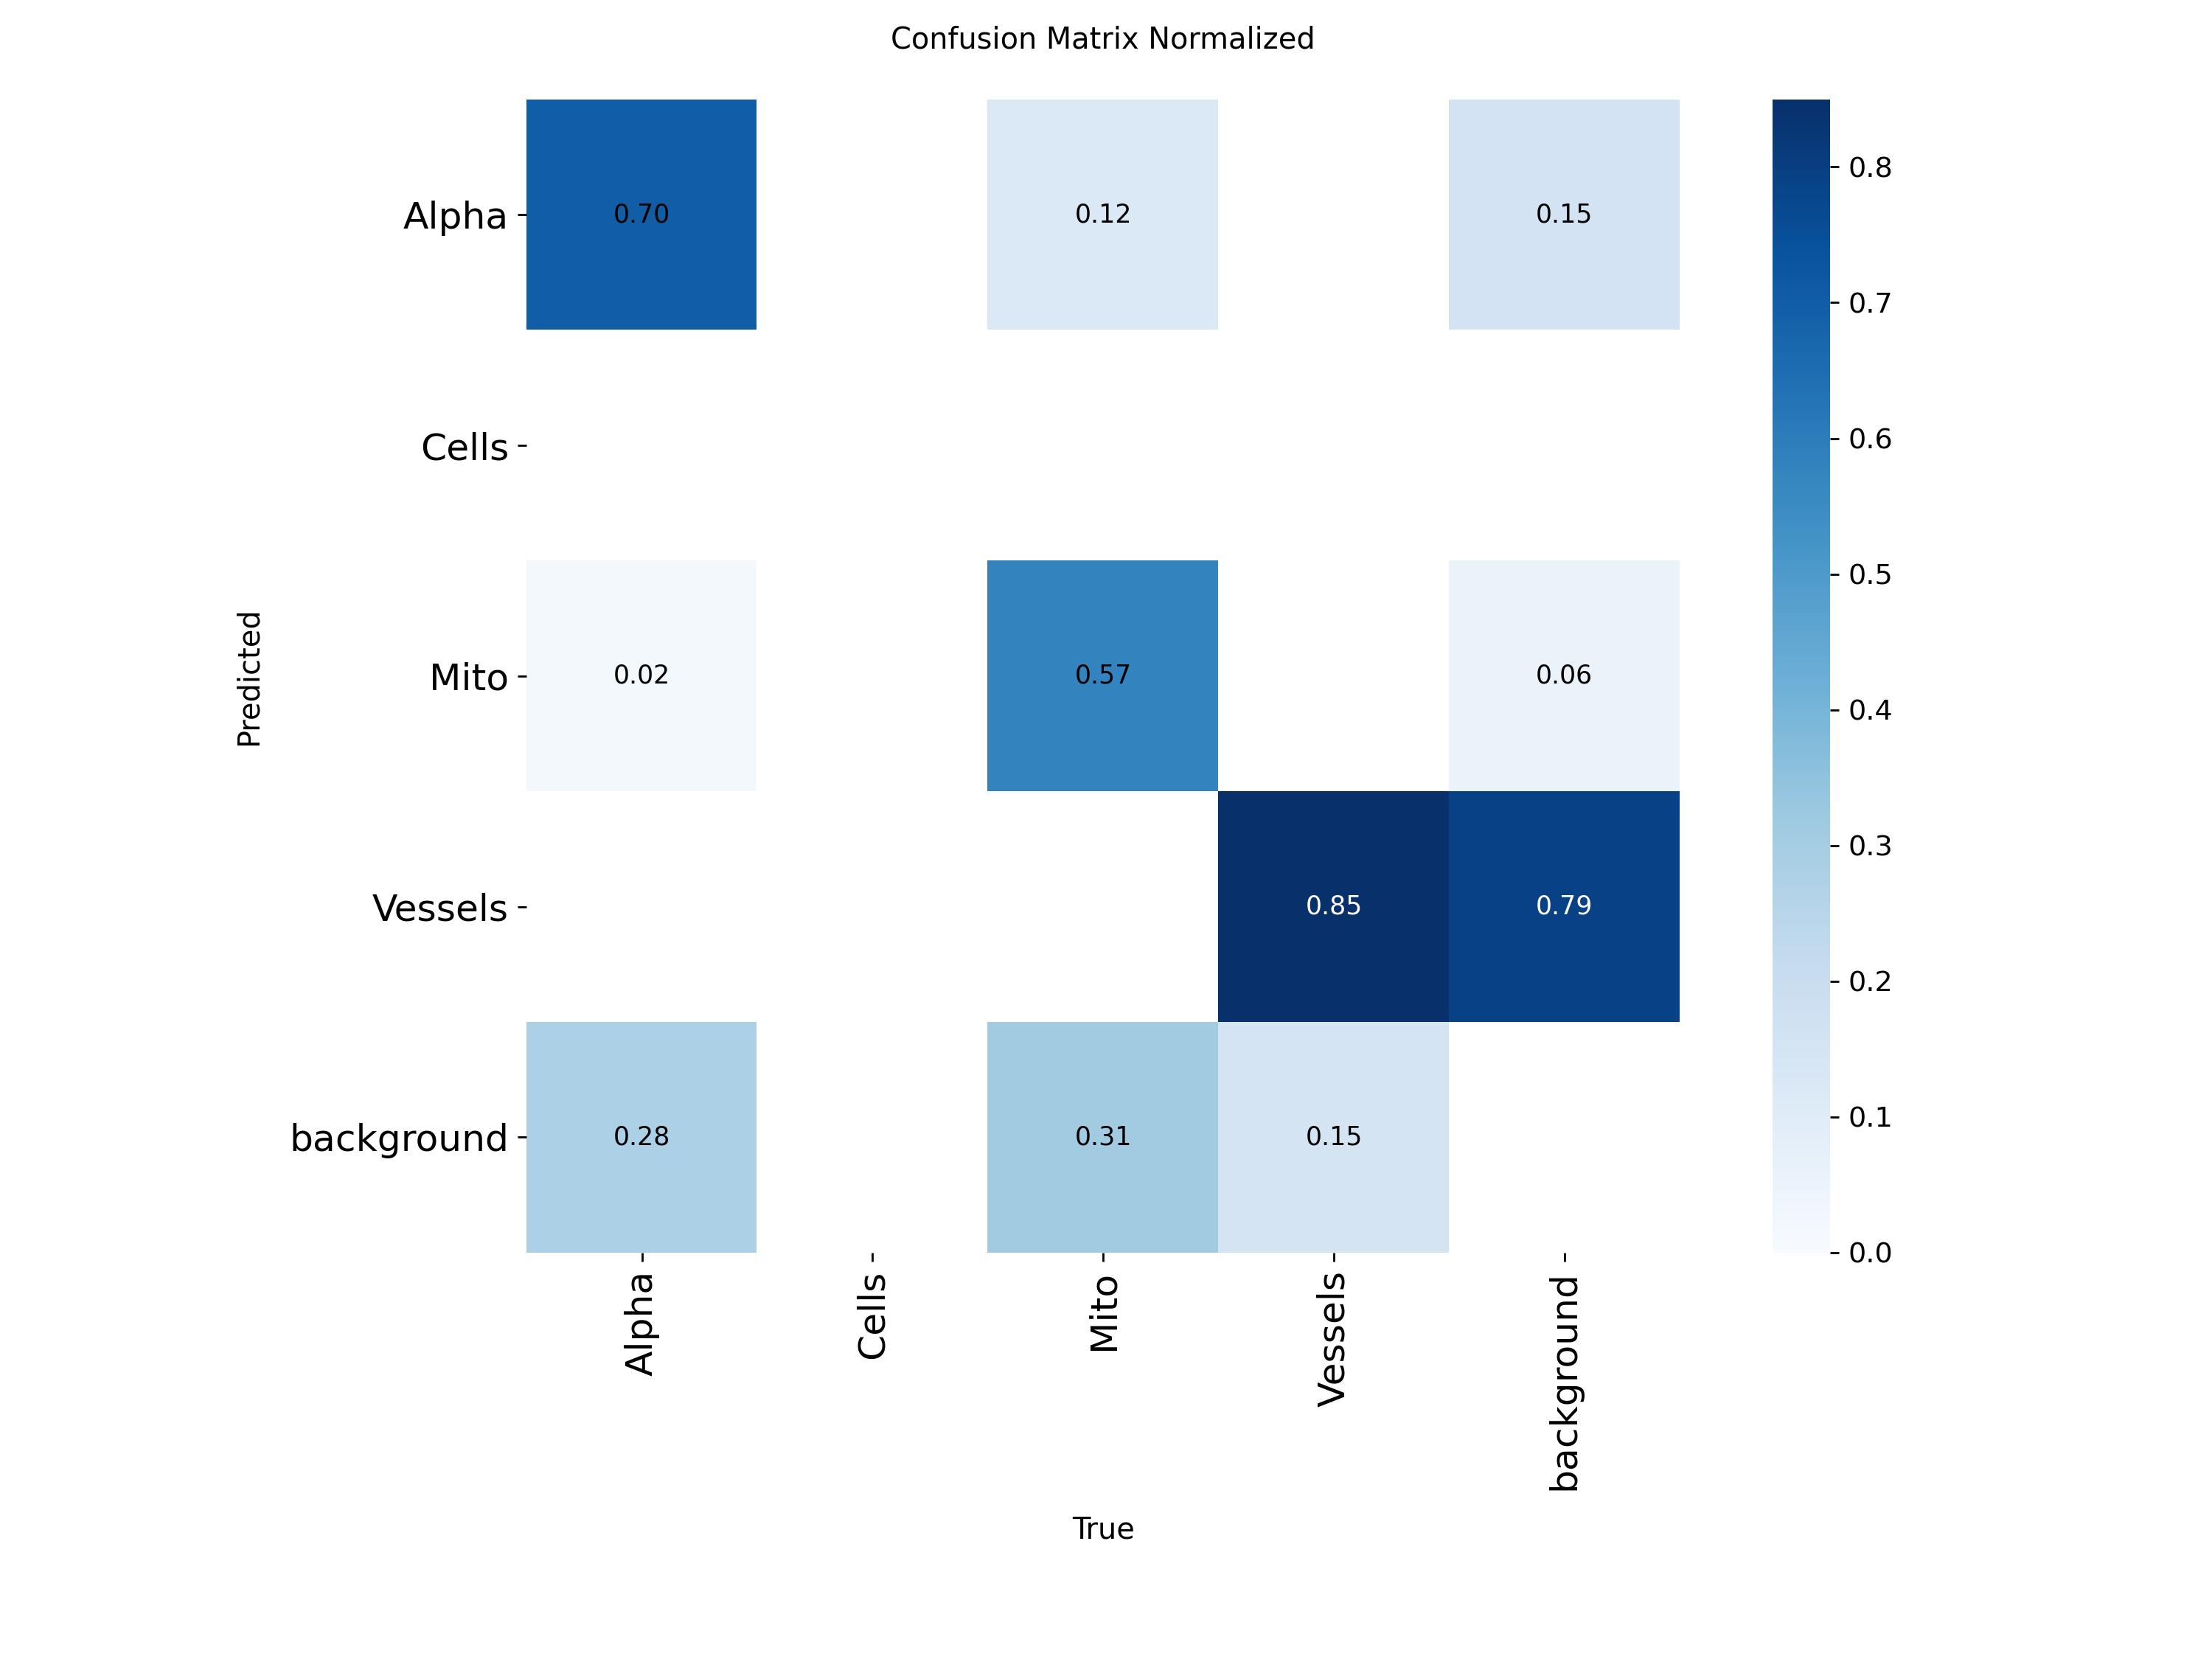

In [12]:
display(Image(filename="./runs/segment/val/confusion_matrix_normalized.png"))

# Predictions

In [43]:
%matplotlib inline

In [44]:
try_image_path = 'yolo_dataset/valid/images/slice_051.png'
predicted = model.predict(try_image_path, conf=0.3)

original_img = np.array(PIL.Image.open(try_image_path))
predicted_img = predicted[0].plot()



image 1/1 c:\Users\acer\Desktop\Code\YOLO\yolo_dataset\valid\images\slice_051.png: 800x800 27 Alphas, 2 Mitos, 62 Vesselss, 203.3ms
Speed: 3.4ms preprocess, 203.3ms inference, 182.9ms postprocess per image at shape (1, 3, 800, 800)


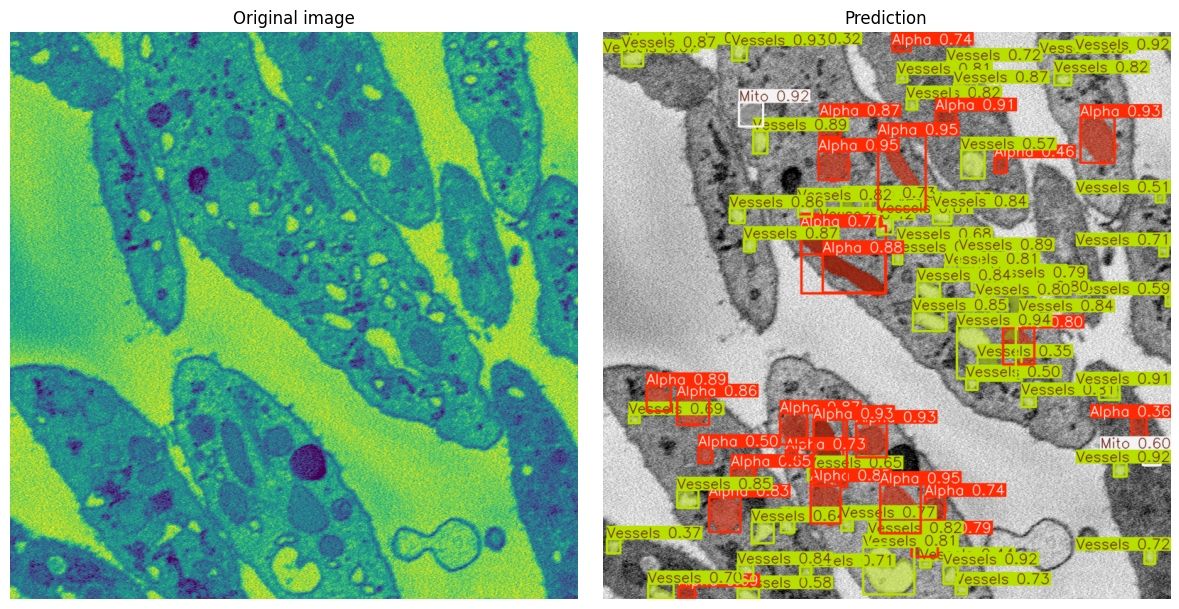

In [45]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(original_img)
plt.title('Original image')
plt.axis('off')

plt.subplot(1,2, 2)
plt.imshow(predicted_img)
plt.title('Prediction')
plt.axis('off')

plt.tight_layout()
plt.show()


# Extracting bounding boxes and segmented masks in numerical form

In [49]:
results = predicted[0]
boxes = results.boxes # this gives coordinates of the boxes
boxes.shape

torch.Size([91, 6])

In [51]:
polyg = results.masks.xyn # gives polygon coordinates of all classes
len(polyg)

91

In [53]:
masks = results.masks.data
masks.shape

torch.Size([91, 800, 800])

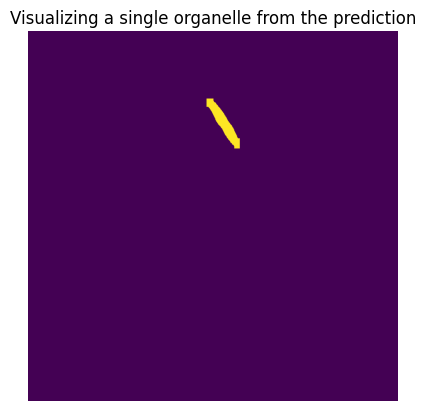

In [65]:
masks_array = masks.cpu().numpy()
plt.imshow(masks_array[0])
plt.title("Visualizing a single organelle from the prediction")
plt.axis("off")
plt.show()

In [74]:
results.names

{0: 'Alpha', 1: 'Cells', 2: 'Mito', 3: 'Vessels'}

In [67]:
class_names = results.names.values()
class_names

dict_values(['Alpha', 'Cells', 'Mito', 'Vessels'])

In [73]:
detected_boxes = results.boxes.data
class_labels = detected_boxes[:, -1].int().tolist()

masks_by_class = {name: [] for name in class_names}

for mask, class_id in zip(masks_array, class_labels):
    class_name = results.names[class_id]
    masks_by_class[class_name].append(mask)

for class_name, masks in masks_by_class.items():
    print(f"Class name: {class_name}, Number of masks: {len(masks)}")

Class name: Alpha, Number of masks: 27
Class name: Cells, Number of masks: 0
Class name: Mito, Number of masks: 2
Class name: Vessels, Number of masks: 62
